In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score


In [5]:
from torchvision import datasets, transforms

torch.manual_seed(42)

# Путь к данным
data_dir = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

# Преобразование для загрузки данных без нормализации

transform = transforms.Compose([
    transforms.ToTensor()
])

# Загрузка полного набора данных
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Разделение на тренировочную, валидационную и тестовую выборки
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Создаем загрузчик для тренировочной выборки
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Вычисляем средние и стандартные отклонения по тренировочной выборке

mean = 0.
std = 0.
n_samples = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # количество изображений в батче
    mean += images.mean(dim=(0, 2, 3)) * batch_samples  # Среднее по каналам для текущего батча
    std += images.std(dim=(0, 2, 3)) * batch_samples   # Стандартное отклонение по каналам для текущего батча
    n_samples += batch_samples

# Окончательное среднее и стандартное отклонение по каналам для всего набора данных
mean /= n_samples
std /= n_samples

print(f"Mean per channel: {mean}")
print(f"Std per channel: {std}")


Mean per channel: tensor([0.6748, 0.6410, 0.6053])
Std per channel: tensor([0.2063, 0.2079, 0.2300])


In [6]:
from torchvision import datasets, transforms

torch.manual_seed(42)

# Путь к данным
data_dir = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

# Преобразование для загрузки данных без нормализации
mean = [0.6748, 0.6410, 0.6053]
std = [0.2063, 0.2079, 0.2300]


# Загрузка полного набора данных
dataset = datasets.ImageFolder(root=data_dir)

# Разделение на тренировочную, валидационную и тестовую выборки
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

val_dataset.dataset.transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

test_dataset.dataset.transform = transforms.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [7]:
def show_images(dataset, num_images = 10):
    # Создаем подграфик 1x10
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))

    for i in range(num_images):
        # Получаем изображение и метку
        image, label = dataset[i]
        # Переводим изображение в формат (H, W, C) для отображения в Matplotlib
        image = image = image.permute(1, 2, 0).numpy()
        # Отображаем изображение
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

    plt.show()

label: 0 - cardboard
label: 1 - glass
label: 2 - metal
label: 3 - paper
label: 4 - plastic
label: 5 - trash
`````````````````````````````````````````````````````````````````````````````````````````
Обучающая выборка: 1768 изображений, доля от общей выборки: 0.7


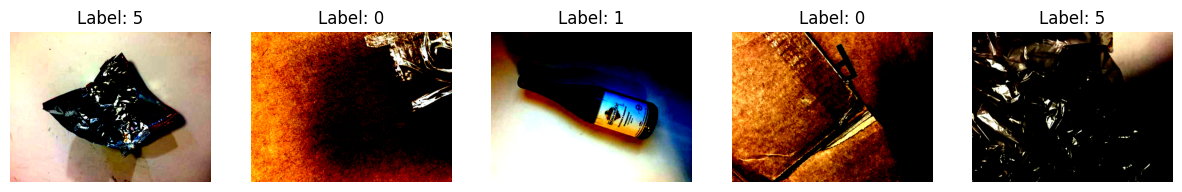

/////////////////////////////////////////////////////////////////////////////////////////
Валидационная выборка: 379 изображений, доля от общей выборки: 0.15


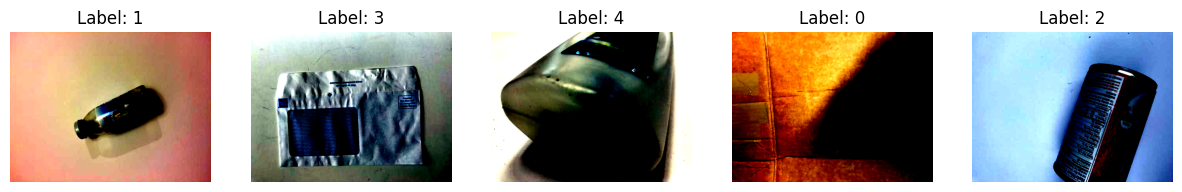

/////////////////////////////////////////////////////////////////////////////////////////
Тестовая выборка: 380 изображений, доля от общей выборки: 0.15


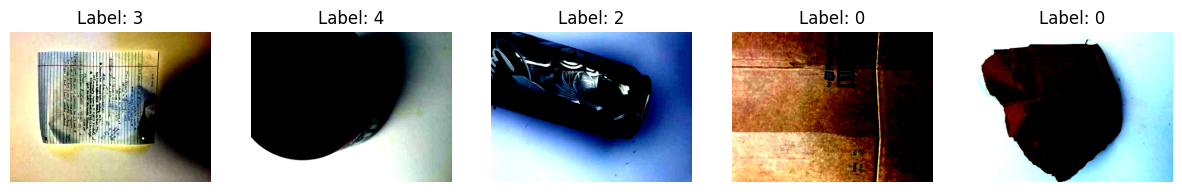

`````````````````````````````````````````````````````````````````````````````````````````


In [8]:
quantity_el_train = len(train_dataset)
quantity_el_val = len(val_dataset)
quantity_el_test = len(test_dataset)

train_ratio = round(len(train_dataset)/len(dataset),3)
val_ratio = round(len(val_dataset)/len(dataset),3)
test_ratio = round(len(test_dataset)/len(dataset),3)

print("label: 0 - cardboard")
print("label: 1 - glass")
print("label: 2 - metal")
print("label: 3 - paper")
print("label: 4 - plastic")
print("label: 5 - trash")
# Проверка размеров выборок
print("`````````````````````````````````````````````````````````````````````````````````````````")
print(f"Обучающая выборка: {quantity_el_train} изображений, доля от общей выборки: {train_ratio}")
show_images(train_dataset, num_images = 5)
print("/////////////////////////////////////////////////////////////////////////////////////////")
print(f"Валидационная выборка: {quantity_el_val} изображений, доля от общей выборки: {val_ratio}")
show_images(val_dataset, num_images = 5)
print("/////////////////////////////////////////////////////////////////////////////////////////")
print(f"Тестовая выборка: {quantity_el_test} изображений, доля от общей выборки: {test_ratio}")
show_images(test_dataset, num_images = 5)
print("`````````````````````````````````````````````````````````````````````````````````````````")

In [9]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def train(model) -> float:
    model.train()

    train_loss = 0
    all_preds = []
    all_labels = []

    for x, y in tqdm(train_loader, desc='Train'):

        bs = y.size(0)
        
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # Прямой проход
        
        output = model(x)
        
        loss = loss_fn(output, y)
        
        # Накопление общей потери
        
        train_loss += loss.item()
        
        # Обратный проход и обновление весов
        
        loss.backward()
        
        optimizer.step()
        
        # Сбор предсказаний и истинных меток для F1-score
        _, y_pred = output.max(dim=1)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # Рассчитываем среднее значение потерь на весь набор данных
    train_loss /= len(train_loader)

    # Рассчитываем Macro F1-score на уровне всего набора данных
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return train_loss, macro_f1


In [10]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # Рассчитываем среднее значение потерь на весь набор данных
    total_loss /= len(loader)

    # Рассчитываем Macro F1-score на уровне всего набора данных
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss, macro_f1

In [11]:
def whole_train_valid_cycle(model, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_macro_f1_history, valid_macro_f1_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_macro_f1 = train(model)
        valid_loss, valid_macro_f1 = evaluate(model, val_loader)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_macro_f1_history.append(train_macro_f1)
        valid_macro_f1_history.append(valid_macro_f1)
        
        print(f"Эпоха {epoch+1}")
        print(f"___Train___ Loss = {train_loss}, Macro_F1 = {train_macro_f1}")
        print(f"___Test___  Loss = {valid_loss}, Macro_F1 = {valid_macro_f1}")

    return train_macro_f1_history, valid_macro_f1_history, train_loss_history, valid_loss_history
            

In [12]:
from torchvision.models import alexnet, densenet121, googlenet, resnet18, vgg16
import torch.nn as nn

def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool=True, train_last_layer_only: bool=False):
    if model_name == "alexnet":
        model = alexnet(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        
        # Замораживаем все слои, кроме последнего
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.classifier[6].weight.requires_grad = True
            model.classifier[6].bias.requires_grad = True
    
    elif model_name == "densenet":
        model = densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.classifier.weight.requires_grad = True
            model.classifier.bias.requires_grad = True
    
    elif model_name == "vgg16":
        model = vgg16(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.classifier[6].weight.requires_grad = True
            model.classifier[6].bias.requires_grad = True

    elif model_name == "resnet18":
        model = resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.fc.weight.requires_grad = True
            model.fc.bias.requires_grad = True

    else:
        raise ValueError(f"Unknown model name {model_name}. Supported models are: alexnet, densenet, googlenet, resnet18")
    
    return model


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
alexnet = get_pretrained_model("alexnet", 6, True, True)
densenet = get_pretrained_model("densenet", 6, True, True)
resnet = get_pretrained_model("resnet18", 6, True, True)
vgg = get_pretrained_model("vgg16", 6, True, True)

# Архитектуры нейронных сетей 

In [5]:
alexnet_1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [55]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [57]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
from torchvision.models import googlenet, resnet50, vgg16, inception_v3
import torch.nn as nn

def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool=True, train_last_layer_only: bool=False):

    if model_name == "resnet50":
        model = resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.fc.weight.requires_grad = True
            model.fc.bias.requires_grad = True

    elif model_name == "googlenet":
        model = googlenet(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.fc.weight.requires_grad = True
            model.fc.bias.requires_grad = True

    elif model_name == "inception":
        # По умолчанию aux_logits=True
        model = inception_v3(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.fc.weight.requires_grad = True
            model.fc.bias.requires_grad = True

        # Отключение aux_logits, если они не нужны
        model.aux_logits = False

    elif model_name == "vgg16":
        model = vgg16(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        
        if train_last_layer_only:
            for param in model.parameters():
                param.requires_grad = False
            model.classifier[6].weight.requires_grad = True
            model.classifier[6].bias.requires_grad = True

    else:
        raise ValueError(f"Unknown model name {model_name}. Supported models are: resnet50, googlenet, inception, vgg16")
    
    return model
#################################################################################################################################
################################################################################################################################
################################################################################################################################

#################################################################################################################################
################################################################################################################################
################################################################################################################################
googlenet_1 = get_pretrained_model("googlenet", 6, True, True)
inception_1 = get_pretrained_model("inception", 6, True, True)
resnet_1 = get_pretrained_model("resnet50", 6, True, True)
vgg_1 = get_pretrained_model("vgg16", 6, True, True)

In [61]:
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()

#Alexnet
print("Alexnet обучение классификатора")
alexnet_1.to(device)
optimizer = optim.Adam(alexnet_1.parameters(), lr=0.001)

train_macro_f1_history_alexnet_1, valid_macro_f1_history_alexnet_1, train_loss_history_alexnet_1, valid_loss_history_alexnet_1 = whole_train_valid_cycle(alexnet_1,
                                                                                                                                                         num_epochs = num_epochs)

#Vgg
print("Vgg обучение классификатора")
vgg_1.to(device)
optimizer = optim.Adam(vgg_1.parameters(), lr=0.001)

train_macro_f1_history_vgg_1, valid_macro_f1_history_vgg_1, train_loss_history_vgg_1, valid_loss_history_vgg_1 = whole_train_valid_cycle(vgg_1,                                                                                                                                                                  
                                                                                                                                         num_epochs = num_epochs)

#Dansenet
print("Dansenet обучение классификатора")
densenet_1.to(device)
optimizer = optim.Adam(densenet_1.parameters(), lr=0.001)

train_macro_f1_history_densenet_1, valid_macro_f1_history_densenet_1, train_loss_history_densenet_1, valid_loss_history_densenet_1 = whole_train_valid_cycle(densenet_1, 
                                                                                                                                                             num_epochs = num_epochs)

#Resnet
print("Resnet обучение классификатора")
resnet_1.to(device)
optimizer = optim.Adam(resnet_1.parameters(), lr=0.001)

train_macro_f1_history_resnet_1, valid_macro_f1_history_resnet_1, train_loss_history_resnet_1, valid_loss_history_resnet_1 = whole_train_valid_cycle(resnet_1,
                                                                                                                                                     num_epochs = num_epochs)

Alexnet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Эпоха 1
___Train___ Loss = 0.6652278953364917, Macro_F1 = 0.7274118107409183
___Test___  Loss = 0.6030804216861725, Macro_F1 = 0.7396171756217785


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Эпоха 2
___Train___ Loss = 0.46198088249989916, Macro_F1 = 0.8086734287717934
___Test___  Loss = 0.5417835613091787, Macro_F1 = 0.7896565306937554


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Эпоха 3
___Train___ Loss = 0.4073331925485815, Macro_F1 = 0.8474299095870231
___Test___  Loss = 0.5389730234940847, Macro_F1 = 0.7858298813955243


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Эпоха 4
___Train___ Loss = 0.34108531794377733, Macro_F1 = 0.8657081471385046
___Test___  Loss = 0.5138282726208369, Macro_F1 = 0.7943670088918301


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Эпоха 5
___Train___ Loss = 0.3063153534063271, Macro_F1 = 0.88156073228481
___Test___  Loss = 0.4937311460574468, Macro_F1 = 0.8047517798744156


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Эпоха 6
___Train___ Loss = 0.2699642080281462, Macro_F1 = 0.9068144443388569
___Test___  Loss = 0.5119755913813909, Macro_F1 = 0.8134767969986337


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Эпоха 7
___Train___ Loss = 0.25006626386727604, Macro_F1 = 0.9111473701485154
___Test___  Loss = 0.47458816568056744, Macro_F1 = 0.8155492634775642


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Эпоха 8
___Train___ Loss = 0.22976442107132503, Macro_F1 = 0.9252702555529835
___Test___  Loss = 0.4689267675081889, Macro_F1 = 0.8182669844301623


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Эпоха 9
___Train___ Loss = 0.20131289666252478, Macro_F1 = 0.939312485610745
___Test___  Loss = 0.473613182703654, Macro_F1 = 0.8209089717131115


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Эпоха 10
___Train___ Loss = 0.19811767233269556, Macro_F1 = 0.9354591363730801
___Test___  Loss = 0.4750715345144272, Macro_F1 = 0.8107328187662874


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Эпоха 11
___Train___ Loss = 0.18729945485080993, Macro_F1 = 0.948123399647737
___Test___  Loss = 0.44086478650569916, Macro_F1 = 0.8300698034094717


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Эпоха 12
___Train___ Loss = 0.18583344934242113, Macro_F1 = 0.9419845239141358
___Test___  Loss = 0.459149236480395, Macro_F1 = 0.8332032497693632


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Эпоха 13
___Train___ Loss = 0.1681030190416745, Macro_F1 = 0.94558620719804
___Test___  Loss = 0.46583231290181476, Macro_F1 = 0.8314477881982508


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Эпоха 14
___Train___ Loss = 0.1617933458515576, Macro_F1 = 0.9423865286026998
___Test___  Loss = 0.46895600855350494, Macro_F1 = 0.8206999523403852


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Эпоха 15
___Train___ Loss = 0.14354518242180347, Macro_F1 = 0.9613965047704888
___Test___  Loss = 0.5187770028909048, Macro_F1 = 0.8058394860884163


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Эпоха 16
___Train___ Loss = 0.1561537967728717, Macro_F1 = 0.9525651877594443
___Test___  Loss = 0.4766853203376134, Macro_F1 = 0.8295413741283734


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Эпоха 17
___Train___ Loss = 0.13013086201889174, Macro_F1 = 0.9665492889123454
___Test___  Loss = 0.5070909212032954, Macro_F1 = 0.8238999534362041


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Эпоха 18
___Train___ Loss = 0.14552210138312408, Macro_F1 = 0.952955272690757
___Test___  Loss = 0.47154119114081067, Macro_F1 = 0.8373510268666764


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Эпоха 19
___Train___ Loss = 0.1371074358799628, Macro_F1 = 0.9621579417609659
___Test___  Loss = 0.5018682777881622, Macro_F1 = 0.8327784751708794


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Эпоха 20
___Train___ Loss = 0.1269473329718624, Macro_F1 = 0.9588641246755781
___Test___  Loss = 0.49077288806438446, Macro_F1 = 0.8292277677708705
Vgg обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 1
___Train___ Loss = 1.0086293071508408, Macro_F1 = 0.5779253834661573
___Test___  Loss = 0.712673177321752, Macro_F1 = 0.7180004489205905


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 2
___Train___ Loss = 0.5846146462219102, Macro_F1 = 0.7538043263154172
___Test___  Loss = 0.5878100643555323, Macro_F1 = 0.7714482856405386


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Эпоха 3
___Train___ Loss = 0.5147567221096584, Macro_F1 = 0.7945726114822972
___Test___  Loss = 0.5573232819636663, Macro_F1 = 0.8110654510309553


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 4
___Train___ Loss = 0.46406942286661695, Macro_F1 = 0.8185169648950303
___Test___  Loss = 0.5509237994750341, Macro_F1 = 0.7797371538532585


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Эпоха 5
___Train___ Loss = 0.420608077198267, Macro_F1 = 0.8378062756764736
___Test___  Loss = 0.5120373517274857, Macro_F1 = 0.7957565682344062


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Эпоха 6
___Train___ Loss = 0.3958843084318297, Macro_F1 = 0.8434843835012941
___Test___  Loss = 0.5027665396531423, Macro_F1 = 0.7943797701449652


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 7
___Train___ Loss = 0.37678250085030285, Macro_F1 = 0.8559429317400961
___Test___  Loss = 0.4896315981944402, Macro_F1 = 0.7954816220082789


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Эпоха 8
___Train___ Loss = 0.3582512140274048, Macro_F1 = 0.8534329603163607
___Test___  Loss = 0.48066064218680066, Macro_F1 = 0.7959184666674441


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Эпоха 9
___Train___ Loss = 0.35056700876780916, Macro_F1 = 0.8545502582349015
___Test___  Loss = 0.47475791970888775, Macro_F1 = 0.7949382193065558


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Эпоха 10
___Train___ Loss = 0.3423535424683775, Macro_F1 = 0.8707478356903278
___Test___  Loss = 0.4743885099887848, Macro_F1 = 0.7940691999908928


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Эпоха 11
___Train___ Loss = 0.30019988705004963, Macro_F1 = 0.8839653727636324
___Test___  Loss = 0.4821569224198659, Macro_F1 = 0.7831176265172282


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 12
___Train___ Loss = 0.29969572967716623, Macro_F1 = 0.8872375285070957
___Test___  Loss = 0.4897146075963974, Macro_F1 = 0.7932405605480838


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Эпоха 13
___Train___ Loss = 0.2955247648060322, Macro_F1 = 0.8868580800048433
___Test___  Loss = 0.4707961132129033, Macro_F1 = 0.8207095874531563


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 14
___Train___ Loss = 0.2921530551144055, Macro_F1 = 0.8926749828383379
___Test___  Loss = 0.461524357398351, Macro_F1 = 0.8064329407141407


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Эпоха 15
___Train___ Loss = 0.2804269960948399, Macro_F1 = 0.8922483059054126
___Test___  Loss = 0.4679011305173238, Macro_F1 = 0.8043851531760623


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 16
___Train___ Loss = 0.26419141037123545, Macro_F1 = 0.8881312224746308
___Test___  Loss = 0.49080083270867664, Macro_F1 = 0.7965494505454429


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 17
___Train___ Loss = 0.2636539361306599, Macro_F1 = 0.9077268813421377
___Test___  Loss = 0.4671556403239568, Macro_F1 = 0.8157421558522581


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 18
___Train___ Loss = 0.25538997032812666, Macro_F1 = 0.9001906308052186
___Test___  Loss = 0.459635669986407, Macro_F1 = 0.8171648117962427


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Эпоха 19
___Train___ Loss = 0.25609684948410305, Macro_F1 = 0.9010165852203734
___Test___  Loss = 0.46403445303440094, Macro_F1 = 0.8023918827823753


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 20
___Train___ Loss = 0.2575816160866192, Macro_F1 = 0.8991975050396902
___Test___  Loss = 0.4534165660540263, Macro_F1 = 0.7986183109250851
Dansenet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 1
___Train___ Loss = 1.5039099540029253, Macro_F1 = 0.356728582402406
___Test___  Loss = 1.2679986357688904, Macro_F1 = 0.5279866911338538


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 2
___Train___ Loss = 1.083344708595957, Macro_F1 = 0.5783790170960679
___Test___  Loss = 1.0171601474285126, Macro_F1 = 0.5813253585921497


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 3
___Train___ Loss = 0.8690901696681976, Macro_F1 = 0.6730856460671747
___Test___  Loss = 0.853616327047348, Macro_F1 = 0.6920484388315863


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 4
___Train___ Loss = 0.7523827190910067, Macro_F1 = 0.7540532433618047
___Test___  Loss = 0.7827397584915161, Macro_F1 = 0.6984831712677361


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 5
___Train___ Loss = 0.6633925501789365, Macro_F1 = 0.7856677002997051
___Test___  Loss = 0.6817705631256104, Macro_F1 = 0.7631056906416708


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 6
___Train___ Loss = 0.6075353931103434, Macro_F1 = 0.801701174182268
___Test___  Loss = 0.6470162371794382, Macro_F1 = 0.7620021518654384


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 7
___Train___ Loss = 0.5599613061973027, Macro_F1 = 0.8250840097561308
___Test___  Loss = 0.6041055421034495, Macro_F1 = 0.7757370631169657


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 8
___Train___ Loss = 0.5281050045575414, Macro_F1 = 0.8362917349755238
___Test___  Loss = 0.5745900472005209, Macro_F1 = 0.8014040271609636


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Эпоха 9
___Train___ Loss = 0.4991946369409561, Macro_F1 = 0.8466446846660612
___Test___  Loss = 0.5628267129262289, Macro_F1 = 0.7729580848192148


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 10
___Train___ Loss = 0.48164189394031254, Macro_F1 = 0.8522693443775594
___Test___  Loss = 0.5566642880439758, Macro_F1 = 0.7663182707945805


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 11
___Train___ Loss = 0.43862516645874294, Macro_F1 = 0.8738876432133066
___Test___  Loss = 0.5120799442132314, Macro_F1 = 0.7845631852945156


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 12
___Train___ Loss = 0.4255618729761669, Macro_F1 = 0.8783414653724689
___Test___  Loss = 0.4911702374617259, Macro_F1 = 0.8338861546401187


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 13
___Train___ Loss = 0.4085232402597155, Macro_F1 = 0.8750302926070344
___Test___  Loss = 0.4876882880926132, Macro_F1 = 0.8076404939116936


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 14
___Train___ Loss = 0.4047221541404724, Macro_F1 = 0.8831272248104493
___Test___  Loss = 0.4814460227886836, Macro_F1 = 0.7983674326392776


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 15
___Train___ Loss = 0.38980574160814285, Macro_F1 = 0.8792024856837616
___Test___  Loss = 0.47763272126515705, Macro_F1 = 0.7965524095473729


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 16
___Train___ Loss = 0.3663770375507219, Macro_F1 = 0.8948213829605794
___Test___  Loss = 0.46494224667549133, Macro_F1 = 0.8073774492856808


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 17
___Train___ Loss = 0.3566982245870999, Macro_F1 = 0.9064510176081102
___Test___  Loss = 0.46080729862054187, Macro_F1 = 0.8007470879550967


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 18
___Train___ Loss = 0.34943085589579176, Macro_F1 = 0.8992173214566983
___Test___  Loss = 0.4586001733938853, Macro_F1 = 0.8061875354557979


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 19
___Train___ Loss = 0.33380803359406336, Macro_F1 = 0.9007484500001692
___Test___  Loss = 0.4425009141365687, Macro_F1 = 0.8133313084712447


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Эпоха 20
___Train___ Loss = 0.3275101546730314, Macro_F1 = 0.9094363675874183
___Test___  Loss = 0.4330265025297801, Macro_F1 = 0.8152339176917266
Resnet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Эпоха 1
___Train___ Loss = 1.5832644530705042, Macro_F1 = 0.32441514570772567
___Test___  Loss = 1.3292336662610371, Macro_F1 = 0.47883539045618556


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Эпоха 2
___Train___ Loss = 1.147739706294877, Macro_F1 = 0.5496974853482122
___Test___  Loss = 1.0616276065508525, Macro_F1 = 0.5646586214564274


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Эпоха 3
___Train___ Loss = 0.9528041992868695, Macro_F1 = 0.6095703257706079
___Test___  Loss = 0.9071855445702871, Macro_F1 = 0.6509841776517233


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Эпоха 4
___Train___ Loss = 0.8501140262399401, Macro_F1 = 0.641053514924942
___Test___  Loss = 0.8540263970692953, Macro_F1 = 0.6628597197136403


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Эпоха 5
___Train___ Loss = 0.760781786271504, Macro_F1 = 0.704911064670954
___Test___  Loss = 0.7666860719521841, Macro_F1 = 0.6696444156216924


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Эпоха 6
___Train___ Loss = 0.6991629877260753, Macro_F1 = 0.7224064861813781
___Test___  Loss = 0.7257135411103567, Macro_F1 = 0.7151196405077241


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Эпоха 7
___Train___ Loss = 0.6665787760700498, Macro_F1 = 0.765120722052702
___Test___  Loss = 0.7152210573355356, Macro_F1 = 0.6966872588452352


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Эпоха 8
___Train___ Loss = 0.6327978989907673, Macro_F1 = 0.7723479089058195
___Test___  Loss = 0.6660692592461904, Macro_F1 = 0.7130829759283824


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Эпоха 9
___Train___ Loss = 0.5888784389410701, Macro_F1 = 0.7935472143021194
___Test___  Loss = 0.6411634186903635, Macro_F1 = 0.7512782780454534


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Эпоха 10
___Train___ Loss = 0.5708634587270873, Macro_F1 = 0.7981904464278987
___Test___  Loss = 0.6337360839049021, Macro_F1 = 0.7575845770043155


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Эпоха 11
___Train___ Loss = 0.5570670206631932, Macro_F1 = 0.7905900019724967
___Test___  Loss = 0.6038654545942942, Macro_F1 = 0.7678687793521864


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Эпоха 12
___Train___ Loss = 0.5267085007258824, Macro_F1 = 0.820788929712429
___Test___  Loss = 0.5784878631432852, Macro_F1 = 0.8005348133255111


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Эпоха 13
___Train___ Loss = 0.5037592596241406, Macro_F1 = 0.8297605629272522
___Test___  Loss = 0.5859482983748118, Macro_F1 = 0.753159839041134


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Эпоха 14
___Train___ Loss = 0.49803691250937326, Macro_F1 = 0.8307304650421107
___Test___  Loss = 0.5572467694679896, Macro_F1 = 0.8164725158320875


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Эпоха 15
___Train___ Loss = 0.48133006585495813, Macro_F1 = 0.8387723193898347
___Test___  Loss = 0.5509344438711802, Macro_F1 = 0.7726291750602177


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


Эпоха 16
___Train___ Loss = 0.4693747056382043, Macro_F1 = 0.8300458147917592
___Test___  Loss = 0.5284970154364904, Macro_F1 = 0.8090317018272802


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Эпоха 17
___Train___ Loss = 0.4567229279450008, Macro_F1 = 0.8434154120508707
___Test___  Loss = 0.538583979010582, Macro_F1 = 0.8123818534052619


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Эпоха 18
___Train___ Loss = 0.4587312915495464, Macro_F1 = 0.8331118412624368
___Test___  Loss = 0.534283384680748, Macro_F1 = 0.7765264143197604


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Эпоха 19
___Train___ Loss = 0.4360100563083376, Macro_F1 = 0.8536449353450039
___Test___  Loss = 0.5082922925551733, Macro_F1 = 0.8217145217781393


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

Эпоха 20
___Train___ Loss = 0.4154144898056984, Macro_F1 = 0.8605436941364148
___Test___  Loss = 0.523931086063385, Macro_F1 = 0.816723384807188


In [19]:
# googlenet_1 = get_pretrained_model("googlenet", 6, True, True)
# inception_1 = get_pretrained_model("inception", 6, True, True)
# resnet_1 = get_pretrained_model("resnet50", 6, True, True)
# vgg_1 = get_pretrained_model("vgg16", 6, True, True)

num_epochs = 1
loss_fn = nn.CrossEntropyLoss()

#Inception
print("Inception обучение классификатора")
inception_1.to(device)
optimizer = optim.Adam(inception_1.parameters(), lr=0.001)

train_macro_f1_history_alexnet_1, valid_macro_f1_history_alexnet_1, train_loss_history_alexnet_1, valid_loss_history_alexnet_1 = whole_train_valid_cycle(inception_1,
                                                                                                                                                         num_epochs = num_epochs)

#Vgg
print("Vgg обучение классификатора")
vgg_1.to(device)
optimizer = optim.Adam(vgg_1.parameters(), lr=0.001)

train_macro_f1_history_vgg_1, valid_macro_f1_history_vgg_1, train_loss_history_vgg_1, valid_loss_history_vgg_1 = whole_train_valid_cycle(vgg_1,                                                                                                                                                                  
                                                                                                                                         num_epochs = num_epochs)

#Googlenet
print("Googlenet обучение классификатора")
googlenet_1.to(device)
optimizer = optim.Adam(googlenet_1.parameters(), lr=0.001)

train_macro_f1_history_densenet_1, valid_macro_f1_history_densenet_1, train_loss_history_densenet_1, valid_loss_history_densenet_1 = whole_train_valid_cycle(googlenet_1, 
                                                                                                                                                             num_epochs = num_epochs)

#Resnet
print("Resnet обучение классификатора")
resnet_1.to(device)
optimizer = optim.Adam(resnet_1.parameters(), lr=0.001)

train_macro_f1_history_resnet_1, valid_macro_f1_history_resnet_1, train_loss_history_resnet_1, valid_loss_history_resnet_1 = whole_train_valid_cycle(resnet_1,
                                                                                                                                                     num_epochs = num_epochs)

inception обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Эпоха 1
___Train___ Loss = 0.22728177878473485, Macro_F1 = 0.917923113427528
___Test___  Loss = 0.3690505673487981, Macro_F1 = 0.8703669222906859
Vgg обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Эпоха 1
___Train___ Loss = 1.865837037563324, Macro_F1 = 0.3786678955692635
___Test___  Loss = 1.3185239831606548, Macro_F1 = 0.3975595921384634
Googlenet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Эпоха 1
___Train___ Loss = 0.2626372128725052, Macro_F1 = 0.8945529558410868
___Test___  Loss = 0.4052872558434804, Macro_F1 = 0.826758491135068
Resnet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

Эпоха 1
___Train___ Loss = 0.37334440063152996, Macro_F1 = 0.8569287331477667
___Test___  Loss = 0.537891298532486, Macro_F1 = 0.8360789022869409


In [62]:
alexnet = get_pretrained_model("alexnet", 6, True, False)
densenet = get_pretrained_model("densenet", 6, True, True)
resnet = get_pretrained_model("resnet18", 6, True, False)
vgg = get_pretrained_model("vgg16", 6, True, True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date 

In [73]:
# Размораживаем последний Dense-блок и все последующие слои
# Разморозим denseblock16
for param in densenet.features.denseblock4.parameters():
    param.requires_grad = True

# Разморозим переходный слой после denseblock4
for param in densenet.features.norm5.parameters():
    param.requires_grad = True
# Теперь обучаются denseblock4, norm5 и classifier


num_epochs = 20
loss_fn = nn.CrossEntropyLoss()

#Dansenet
print("Dansenet обучение denseblock4, norm5 и classifier") 
densenet.to(device)
optimizer = optim.Adam(densenet.parameters(), lr=0.001)

train_macro_f1_history_densenet, valid_macro_f1_history_densenet, train_loss_history_densenet, valid_loss_history_densenet = whole_train_valid_cycle(densenet, 
                                                                                                                                                     num_epochs = num_epochs)

#Alexnet
print("Alexnet обучение всех слоев с начальной инициализацией") 
alexnet.to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

train_macro_f1_history_alexnet, valid_macro_f1_history_alexnet, train_loss_history_alexnet, valid_loss_history_alexnet = whole_train_valid_cycle(alexnet, 
                                                                                                                                                 num_epochs = num_epochs)

#Resnet
print("Resnet обучение всех слоев с начальной инициализацией") 
resnet.to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

train_macro_f1_history_resnet, valid_macro_f1_history_resnet, train_loss_history_resnet, valid_loss_history_resnet = whole_train_valid_cycle(resnet,
                                                                                                                                             num_epochs = num_epochs)

#Vgg
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
for param in vgg.features[-8:].parameters():  
    param.requires_grad = True
    
print("Vgg обучение классификатора и 4-х сверточных слоев") 
vgg.to(device)
optimizer = optim.Adam(vgg.parameters(), lr=0.001)

train_macro_f1_history_vgg, valid_macro_f1_history_vgg, train_loss_history_vgg, valid_loss_history_vgg = whole_train_valid_cycle(vgg, 
                                                                                                                                 num_epochs = num_epochs)

Dansenet обучение denseblock4, norm5 и classifier


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 1
___Train___ Loss = 0.01701367153821463, Macro_F1 = 0.9885478191891361
___Test___  Loss = 0.49198052287101746, Macro_F1 = 0.8701681188958021


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 2
___Train___ Loss = 0.019282413517690396, Macro_F1 = 0.9921837393011893
___Test___  Loss = 0.3485531806945801, Macro_F1 = 0.9031817910939881


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 3
___Train___ Loss = 0.011599573056238504, Macro_F1 = 0.9943551687643059
___Test___  Loss = 0.36498837421337765, Macro_F1 = 0.9054644322843829


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Эпоха 4
___Train___ Loss = 0.006474911540343393, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.44232193132241565, Macro_F1 = 0.8696569394672199


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Эпоха 5
___Train___ Loss = 0.0069038606568158556, Macro_F1 = 0.9969538246412281
___Test___  Loss = 0.4058851475516955, Macro_F1 = 0.8949961217851126


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 6
___Train___ Loss = 0.0066705408340307516, Macro_F1 = 0.996454273318757
___Test___  Loss = 0.41576236734787625, Macro_F1 = 0.8844635940900308


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 7
___Train___ Loss = 0.006775158171097116, Macro_F1 = 0.9974700540877012
___Test___  Loss = 0.41477618118127185, Macro_F1 = 0.8884988612936241


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 8
___Train___ Loss = 0.03114123963470255, Macro_F1 = 0.9916192797160192
___Test___  Loss = 1.4120956758658092, Macro_F1 = 0.7406580525392116


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Эпоха 9
___Train___ Loss = 0.026335206152387918, Macro_F1 = 0.9939345511818302
___Test___  Loss = 0.4339662070075671, Macro_F1 = 0.8811579688786401


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Эпоха 10
___Train___ Loss = 0.0072661665612291215, Macro_F1 = 0.9979997309628356
___Test___  Loss = 0.37626128395398456, Macro_F1 = 0.9037234667658506


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 11
___Train___ Loss = 0.0030525161859519096, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.36828495810429257, Macro_F1 = 0.9073038035408976


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Эпоха 12
___Train___ Loss = 0.0034256633901220213, Macro_F1 = 0.9990311385598417
___Test___  Loss = 0.36393820742766064, Macro_F1 = 0.9077933696609204


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 13
___Train___ Loss = 0.0024784300799832897, Macro_F1 = 0.9990315144359169
___Test___  Loss = 0.3708845004439354, Macro_F1 = 0.9054149371811676


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Эпоха 14
___Train___ Loss = 0.0026583856576962717, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.36554815123478573, Macro_F1 = 0.9120540242167837


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 15
___Train___ Loss = 0.0018350579065164701, Macro_F1 = 0.9990311385598417
___Test___  Loss = 0.34233569477995235, Macro_F1 = 0.9119792464904188


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Эпоха 16
___Train___ Loss = 0.0020418179821847715, Macro_F1 = 0.9990315144359169
___Test___  Loss = 0.3351251905163129, Macro_F1 = 0.9117540378874632


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 17
___Train___ Loss = 0.0022883900661067207, Macro_F1 = 0.9990313347054921
___Test___  Loss = 0.34783463925123215, Macro_F1 = 0.9187785000344197


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 18
___Train___ Loss = 0.0021146457527590557, Macro_F1 = 0.9990313347054921
___Test___  Loss = 0.32400769367814064, Macro_F1 = 0.9123948037821338


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 19
___Train___ Loss = 0.0023659332339645645, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.3161407796045144, Macro_F1 = 0.9078551401692593


Evaluation: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Эпоха 20
___Train___ Loss = 0.001912145540083137, Macro_F1 = 0.9985471399321436
___Test___  Loss = 0.3279488446811835, Macro_F1 = 0.9167104213676126
Alexnet обучение всех слоев с начальной инициализацией


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Эпоха 1
___Train___ Loss = 1.722062566450664, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7412434021631877, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Эпоха 2
___Train___ Loss = 1.7209480788026537, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7431397835413616, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Эпоха 3
___Train___ Loss = 1.7195110661642892, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7404489119847615, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


Эпоха 4
___Train___ Loss = 1.719180852174759, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.743065059185028, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Эпоха 5
___Train___ Loss = 1.7201954807553972, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7395165761311848, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Эпоха 6
___Train___ Loss = 1.7209089057786124, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7417359948158264, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Эпоха 7
___Train___ Loss = 1.7209076029913766, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7382314801216125, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Эпоха 8
___Train___ Loss = 1.7202998059136527, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7406288186709087, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


Эпоха 9
___Train___ Loss = 1.7205736466816492, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7405507763226826, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Эпоха 10
___Train___ Loss = 1.7186012991837092, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7404194076855977, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Эпоха 11
___Train___ Loss = 1.7200012973376684, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7383447488149006, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Эпоха 12
___Train___ Loss = 1.72170005100114, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.741204857826233, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Эпоха 13
___Train___ Loss = 1.7202668147427695, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7445268432299297, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Эпоха 14
___Train___ Loss = 1.7231269649096899, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7369829813639324, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Эпоха 15
___Train___ Loss = 1.722115431513105, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7389822403589885, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Эпоха 16
___Train___ Loss = 1.7234641185828619, Macro_F1 = 0.08022382030941957
___Test___  Loss = 1.7439918716748555, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


Эпоха 17
___Train___ Loss = 1.7232083635670798, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7419910629590352, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Эпоха 18
___Train___ Loss = 1.7186286875179835, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7409854133923848, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Эпоха 19
___Train___ Loss = 1.720387692962374, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.7427428166071575, Macro_F1 = 0.05988455988455988


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Эпоха 20
___Train___ Loss = 1.7210260927677155, Macro_F1 = 0.0638622161255906
___Test___  Loss = 1.739664097627004, Macro_F1 = 0.05988455988455988
Resnet обучение всех слоев с начальной инициализацией


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.00it/s]


Эпоха 1
___Train___ Loss = 0.7969966743673597, Macro_F1 = 0.66114828644602
___Test___  Loss = 9.136220137278238, Macro_F1 = 0.32895485208738084


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Эпоха 2
___Train___ Loss = 0.4862087086907455, Macro_F1 = 0.7811364019266204
___Test___  Loss = 0.8681959609190623, Macro_F1 = 0.7241963232477787


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Эпоха 3
___Train___ Loss = 0.3477942847779819, Macro_F1 = 0.8599065668213023
___Test___  Loss = 0.6324050078789393, Macro_F1 = 0.7648255413489874


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Эпоха 4
___Train___ Loss = 0.25589325092732906, Macro_F1 = 0.9054871873066008
___Test___  Loss = 0.9194031655788422, Macro_F1 = 0.670829284541144


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Эпоха 5
___Train___ Loss = 0.23742113980863774, Macro_F1 = 0.9160318191514364
___Test___  Loss = 0.6861518969138464, Macro_F1 = 0.7019064169489192


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


Эпоха 6
___Train___ Loss = 0.20250750838645867, Macro_F1 = 0.9216760708146073
___Test___  Loss = 0.913384735584259, Macro_F1 = 0.6691366012371094


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Эпоха 7
___Train___ Loss = 0.12610575756324188, Macro_F1 = 0.9521270891856682
___Test___  Loss = 0.7366341253121694, Macro_F1 = 0.7323154088729039


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Эпоха 8
___Train___ Loss = 0.07047878698046718, Macro_F1 = 0.9771013828826214
___Test___  Loss = 0.5566454380750656, Macro_F1 = 0.8442610504594312


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Эпоха 9
___Train___ Loss = 0.0958294365555048, Macro_F1 = 0.9674828744458494
___Test___  Loss = 0.4313578059275945, Macro_F1 = 0.8640105646124003


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Эпоха 10
___Train___ Loss = 0.06263690774462052, Macro_F1 = 0.98515459822605
___Test___  Loss = 0.4463804364204407, Macro_F1 = 0.8536806597102151


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Эпоха 11
___Train___ Loss = 0.04117232740723661, Macro_F1 = 0.98805999328324
___Test___  Loss = 0.6193754573663076, Macro_F1 = 0.8057929181650634


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Эпоха 12
___Train___ Loss = 0.05494405289313623, Macro_F1 = 0.9793335437340697
___Test___  Loss = 0.6416763464609782, Macro_F1 = 0.778288066188856


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Эпоха 13
___Train___ Loss = 0.06874526252171823, Macro_F1 = 0.9789647247538621
___Test___  Loss = 1.956119696299235, Macro_F1 = 0.5995577752137452


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


Эпоха 14
___Train___ Loss = 0.10235731120753501, Macro_F1 = 0.9653113787891588
___Test___  Loss = 1.078143576780955, Macro_F1 = 0.7078073756109539


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Эпоха 15
___Train___ Loss = 0.09274502361326345, Macro_F1 = 0.9620226216226339
___Test___  Loss = 0.4974232167005539, Macro_F1 = 0.8203595507047766


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Эпоха 16
___Train___ Loss = 0.04747862698111151, Macro_F1 = 0.9791113675353285
___Test___  Loss = 0.5898792097965876, Macro_F1 = 0.8302234855799121


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Эпоха 17
___Train___ Loss = 0.024426183064601252, Macro_F1 = 0.9912650374995587
___Test___  Loss = 0.4862529511253039, Macro_F1 = 0.8483906307732582


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Эпоха 18
___Train___ Loss = 0.0200153434915202, Macro_F1 = 0.9957559051206917
___Test___  Loss = 0.48379277686278027, Macro_F1 = 0.8520162614742279


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Эпоха 19
___Train___ Loss = 0.017082474764070606, Macro_F1 = 0.9961471986394957
___Test___  Loss = 0.3923162519931793, Macro_F1 = 0.876644979297548


Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Эпоха 20
___Train___ Loss = 0.01977632249846855, Macro_F1 = 0.9956881943273759
___Test___  Loss = 0.3952598695953687, Macro_F1 = 0.8851134269259248
Vgg обучение классификатора и 4-х сверточных слоев


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


Эпоха 1
___Train___ Loss = 1.278340818645718, Macro_F1 = 0.41673141889248916
___Test___  Loss = 1.0832044730583827, Macro_F1 = 0.45255360381917237


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Эпоха 2
___Train___ Loss = 0.8560188724114014, Macro_F1 = 0.5593900407580495
___Test___  Loss = 0.7629797259966532, Macro_F1 = 0.5940232339988142


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 3
___Train___ Loss = 0.6302829536500277, Macro_F1 = 0.6644727920385973
___Test___  Loss = 0.6178936312596003, Macro_F1 = 0.7326909867396029


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 4
___Train___ Loss = 0.5207293082599167, Macro_F1 = 0.7401418063182056
___Test___  Loss = 0.6545203160494566, Macro_F1 = 0.7395873280680311


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 5
___Train___ Loss = 0.29545481698503634, Macro_F1 = 0.8731314562718681
___Test___  Loss = 0.5758369704708457, Macro_F1 = 0.7505530624615843


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]


Эпоха 6
___Train___ Loss = 0.2904559360598927, Macro_F1 = 0.8836467060759691
___Test___  Loss = 0.5392600577324629, Macro_F1 = 0.8130558814208194


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.88it/s]


Эпоха 7
___Train___ Loss = 0.21431375024756333, Macro_F1 = 0.919699710139878
___Test___  Loss = 0.602002115920186, Macro_F1 = 0.8017825904560504


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Эпоха 8
___Train___ Loss = 0.2803085484323805, Macro_F1 = 0.8895207996837101
___Test___  Loss = 0.6152959118286768, Macro_F1 = 0.806481811180216


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 9
___Train___ Loss = 0.23244299785857275, Macro_F1 = 0.9105971473058112
___Test___  Loss = 0.6654289259264866, Macro_F1 = 0.8122435774917638


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 10
___Train___ Loss = 0.1292723596016331, Macro_F1 = 0.9540988933590141
___Test___  Loss = 0.9930510874837637, Macro_F1 = 0.8036922687441178


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Эпоха 11
___Train___ Loss = 0.1811765436682722, Macro_F1 = 0.9437353940879056
___Test___  Loss = 0.6369916194429001, Macro_F1 = 0.8313750142864459


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Эпоха 12
___Train___ Loss = 0.13531517165756668, Macro_F1 = 0.9471269128614757
___Test___  Loss = 0.5911555700004101, Macro_F1 = 0.8402954416428727


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]


Эпоха 13
___Train___ Loss = 0.09622370508831253, Macro_F1 = 0.9656416946294127
___Test___  Loss = 0.6255497556800643, Macro_F1 = 0.8260597325578792


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


Эпоха 14
___Train___ Loss = 0.10660952226120375, Macro_F1 = 0.9752928364466147
___Test___  Loss = 0.7582219457253814, Macro_F1 = 0.8075581248304519


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]


Эпоха 15
___Train___ Loss = 0.1165511237164652, Macro_F1 = 0.9594129692893049
___Test___  Loss = 0.6531868184295794, Macro_F1 = 0.8266494884696388


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 16
___Train___ Loss = 0.09157627359387777, Macro_F1 = 0.9677229809684076
___Test___  Loss = 0.7305278543693324, Macro_F1 = 0.7976026397443782


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Эпоха 17
___Train___ Loss = 0.14192249005354168, Macro_F1 = 0.9617310550137815
___Test___  Loss = 0.5642435463766257, Macro_F1 = 0.8421744741976206


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


Эпоха 18
___Train___ Loss = 0.093399879569096, Macro_F1 = 0.9757240073159877
___Test___  Loss = 0.7747208745762085, Macro_F1 = 0.8064014093732079


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.87it/s]


Эпоха 19
___Train___ Loss = 0.12469879850306809, Macro_F1 = 0.9654492772108129
___Test___  Loss = 0.7477091200028857, Macro_F1 = 0.8043043813119444


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]

Эпоха 20
___Train___ Loss = 0.09597696401692087, Macro_F1 = 0.9674017304035036
___Test___  Loss = 0.5899940305777515, Macro_F1 = 0.8408404801700574


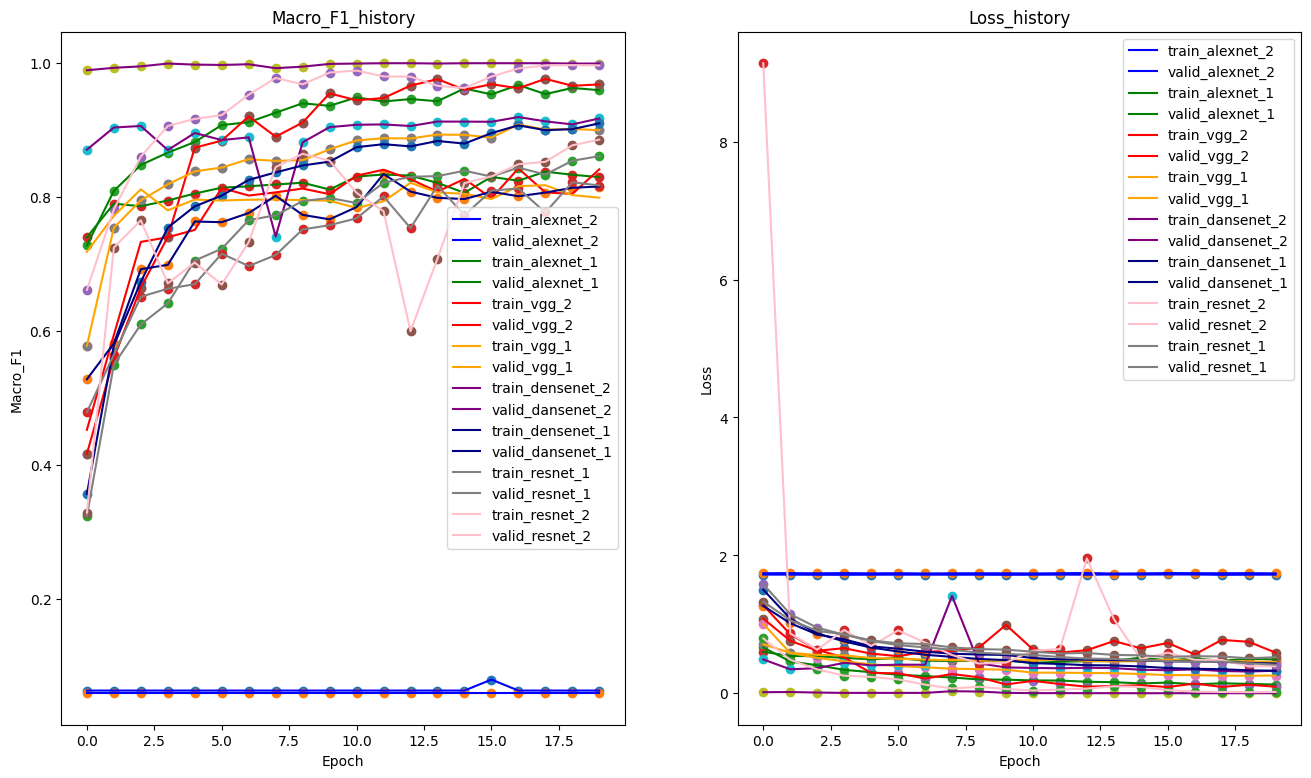

In [93]:
fig = plt.figure()
fig.set_size_inches(16, 9)

ax_1 = fig.add_subplot(1,2,1)

ax_1.plot(range(num_epochs), train_macro_f1_history_alexnet, label="train_alexnet_2", color="blue")
ax_1.plot(range(num_epochs), valid_macro_f1_history_alexnet, label="valid_alexnet_2", color="blue")
ax_1.scatter(range(num_epochs), train_macro_f1_history_alexnet)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_alexnet)

ax_1.plot(range(num_epochs), train_macro_f1_history_alexnet_1, label="train_alexnet_1", color="green")
ax_1.plot(range(num_epochs), valid_macro_f1_history_alexnet_1, label="valid_alexnet_1", color="green")
ax_1.scatter(range(num_epochs), train_macro_f1_history_alexnet_1)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_alexnet_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_vgg, label="train_vgg_2", color="red")
ax_1.plot(range(num_epochs), valid_macro_f1_history_vgg, label="valid_vgg_2", color="red")
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg)
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg)

ax_1.plot(range(num_epochs), train_macro_f1_history_vgg_1, label="train_vgg_1", color="orange")
ax_1.plot(range(num_epochs), valid_macro_f1_history_vgg_1, label="valid_vgg_1", color="orange")
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg_1)
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_densenet, label="train_densenet_2", color="purple")
ax_1.plot(range(num_epochs), valid_macro_f1_history_densenet, label="valid_dansenet_2", color="purple")
ax_1.scatter(range(num_epochs), train_macro_f1_history_densenet)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_densenet)

ax_1.plot(range(num_epochs), train_macro_f1_history_densenet_1, label="train_densenet_1", color="navy")
ax_1.plot(range(num_epochs), valid_macro_f1_history_densenet_1, label="valid_dansenet_1", color="navy")
ax_1.scatter(range(num_epochs), train_macro_f1_history_densenet_1)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_densenet_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_resnet_1, label="train_resnet_1", color="gray")
ax_1.plot(range(num_epochs), valid_macro_f1_history_resnet_1, label="valid_resnet_1", color="gray")
ax_1.scatter(range(num_epochs), train_macro_f1_history_resnet_1)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_resnet_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_resnet, label="train_resnet_2", color="pink")
ax_1.plot(range(num_epochs), valid_macro_f1_history_resnet, label="valid_resnet_2", color="pink")
ax_1.scatter(range(num_epochs), train_macro_f1_history_resnet)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_resnet)


plt.xlabel("Epoch")
plt.ylabel("Macro_F1")
plt.title("Macro_F1_history")
plt.legend()

ax_2 = fig.add_subplot(1,2,2)

ax_2.plot(range(num_epochs), train_loss_history_alexnet, label="train_alexnet_2", color="blue")
ax_2.plot(range(num_epochs), valid_loss_history_alexnet, label="valid_alexnet_2", color="blue")
ax_2.scatter(range(num_epochs), train_loss_history_alexnet)
ax_2.scatter(range(num_epochs), valid_loss_history_alexnet)

ax_2.plot(range(num_epochs), train_loss_history_alexnet_1, label="train_alexnet_1", color="green")
ax_2.plot(range(num_epochs), valid_loss_history_alexnet_1, label="valid_alexnet_1", color="green")
ax_2.scatter(range(num_epochs), train_loss_history_alexnet_1)
ax_2.scatter(range(num_epochs), valid_loss_history_alexnet_1)

ax_2.plot(range(num_epochs), train_loss_history_vgg, label="train_vgg_2", color="red")
ax_2.plot(range(num_epochs), valid_loss_history_vgg, label="valid_vgg_2", color="red")
ax_2.scatter(range(num_epochs), train_loss_history_vgg)
ax_2.scatter(range(num_epochs), valid_loss_history_vgg)

ax_2.plot(range(num_epochs), train_loss_history_vgg_1, label="train_vgg_1", color="orange")
ax_2.plot(range(num_epochs), valid_loss_history_vgg_1, label="valid_vgg_1", color="orange")
ax_2.scatter(range(num_epochs), train_loss_history_vgg_1)
ax_2.scatter(range(num_epochs), valid_loss_history_vgg_1)

ax_2.plot(range(num_epochs), train_loss_history_densenet, label="train_dansenet_2", color="purple")
ax_2.plot(range(num_epochs), valid_loss_history_densenet, label="valid_dansenet_2", color="purple")
ax_2.scatter(range(num_epochs), train_loss_history_densenet)
ax_2.scatter(range(num_epochs), valid_loss_history_densenet)

ax_2.plot(range(num_epochs), train_loss_history_densenet_1, label="train_dansenet_1", color="navy")
ax_2.plot(range(num_epochs), valid_loss_history_densenet_1, label="valid_dansenet_1", color="navy")
ax_2.scatter(range(num_epochs), train_loss_history_densenet_1)
ax_2.scatter(range(num_epochs), valid_loss_history_densenet_1)

ax_2.plot(range(num_epochs), train_loss_history_resnet, label="train_resnet_2", color="pink")
ax_2.plot(range(num_epochs), valid_loss_history_resnet, label="valid_resnet_2", color="pink")
ax_2.scatter(range(num_epochs), train_loss_history_resnet)
ax_2.scatter(range(num_epochs), valid_loss_history_resnet)

ax_2.plot(range(num_epochs), train_loss_history_resnet_1, label="train_resnet_1", color="gray")
ax_2.plot(range(num_epochs), valid_loss_history_resnet_1, label="valid_resnet_1", color="gray")
ax_2.scatter(range(num_epochs), train_loss_history_resnet_1)
ax_2.scatter(range(num_epochs), valid_loss_history_resnet_1)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss_history")
plt.legend()

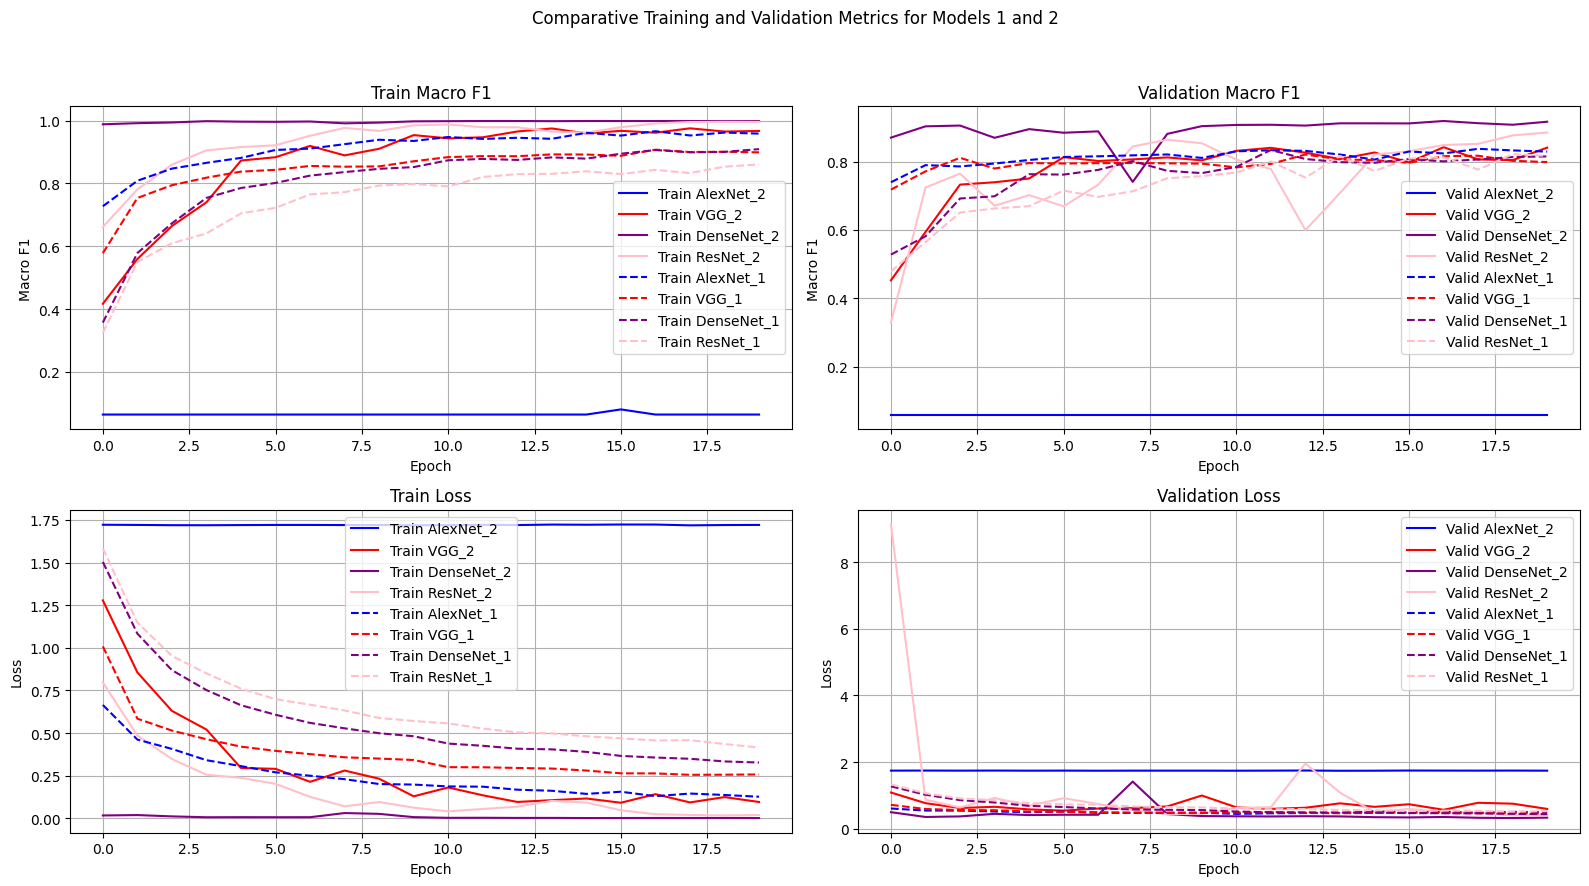

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.suptitle("Comparative Training and Validation Metrics for Models 1 and 2")

# Подграфик для Train Macro F1 для всех моделей
ax_1 = axes[0, 0]
# Модели версии 2
ax_1.plot(range(num_epochs), train_macro_f1_history_alexnet, label="Train AlexNet_2", color="blue", linestyle='-')
ax_1.plot(range(num_epochs), train_macro_f1_history_vgg, label="Train VGG_2", color="red", linestyle='-')
ax_1.plot(range(num_epochs), train_macro_f1_history_densenet, label="Train DenseNet_2", color="purple", linestyle='-')
ax_1.plot(range(num_epochs), train_macro_f1_history_resnet, label="Train ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_1.plot(range(num_epochs), train_macro_f1_history_alexnet_1, label="Train AlexNet_1", color="blue", linestyle='--')
ax_1.plot(range(num_epochs), train_macro_f1_history_vgg_1, label="Train VGG_1", color="red", linestyle='--')
ax_1.plot(range(num_epochs), train_macro_f1_history_densenet_1, label="Train DenseNet_1", color="purple", linestyle='--')
ax_1.plot(range(num_epochs), train_macro_f1_history_resnet_1, label="Train ResNet_1", color="pink", linestyle='--')

ax_1.set_title("Train Macro F1")
ax_1.set_xlabel("Epoch")
ax_1.set_ylabel("Macro F1")
ax_1.legend()
ax_1.grid(True)

# Подграфик для Validation Macro F1 для всех моделей
ax_2 = axes[0, 1]
# Модели версии 2
ax_2.plot(range(num_epochs), valid_macro_f1_history_alexnet, label="Valid AlexNet_2", color="blue", linestyle='-')
ax_2.plot(range(num_epochs), valid_macro_f1_history_vgg, label="Valid VGG_2", color="red", linestyle='-')
ax_2.plot(range(num_epochs), valid_macro_f1_history_densenet, label="Valid DenseNet_2", color="purple", linestyle='-')
ax_2.plot(range(num_epochs), valid_macro_f1_history_resnet, label="Valid ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_2.plot(range(num_epochs), valid_macro_f1_history_alexnet_1, label="Valid AlexNet_1", color="blue", linestyle='--')
ax_2.plot(range(num_epochs), valid_macro_f1_history_vgg_1, label="Valid VGG_1", color="red", linestyle='--')
ax_2.plot(range(num_epochs), valid_macro_f1_history_densenet_1, label="Valid DenseNet_1", color="purple", linestyle='--')
ax_2.plot(range(num_epochs), valid_macro_f1_history_resnet_1, label="Valid ResNet_1", color="pink", linestyle='--')

ax_2.set_title("Validation Macro F1")
ax_2.set_xlabel("Epoch")
ax_2.set_ylabel("Macro F1")
ax_2.legend()
ax_2.grid(True)

# Подграфик для Train Loss для всех моделей
ax_3 = axes[1, 0]
# Модели версии 2
ax_3.plot(range(num_epochs), train_loss_history_alexnet, label="Train AlexNet_2", color="blue", linestyle='-')
ax_3.plot(range(num_epochs), train_loss_history_vgg, label="Train VGG_2", color="red", linestyle='-')
ax_3.plot(range(num_epochs), train_loss_history_densenet, label="Train DenseNet_2", color="purple", linestyle='-')
ax_3.plot(range(num_epochs), train_loss_history_resnet, label="Train ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_3.plot(range(num_epochs), train_loss_history_alexnet_1, label="Train AlexNet_1", color="blue", linestyle='--')
ax_3.plot(range(num_epochs), train_loss_history_vgg_1, label="Train VGG_1", color="red", linestyle='--')
ax_3.plot(range(num_epochs), train_loss_history_densenet_1, label="Train DenseNet_1", color="purple", linestyle='--')
ax_3.plot(range(num_epochs), train_loss_history_resnet_1, label="Train ResNet_1", color="pink", linestyle='--')

ax_3.set_title("Train Loss")
ax_3.set_xlabel("Epoch")
ax_3.set_ylabel("Loss")
ax_3.legend()
ax_3.grid(True)

# Подграфик для Validation Loss для всех моделей
ax_4 = axes[1, 1]
# Модели версии 2
ax_4.plot(range(num_epochs), valid_loss_history_alexnet, label="Valid AlexNet_2", color="blue", linestyle='-')
ax_4.plot(range(num_epochs), valid_loss_history_vgg, label="Valid VGG_2", color="red", linestyle='-')
ax_4.plot(range(num_epochs), valid_loss_history_densenet, label="Valid DenseNet_2", color="purple", linestyle='-')
ax_4.plot(range(num_epochs), valid_loss_history_resnet, label="Valid ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_4.plot(range(num_epochs), valid_loss_history_alexnet_1, label="Valid AlexNet_1", color="blue", linestyle='--')
ax_4.plot(range(num_epochs), valid_loss_history_vgg_1, label="Valid VGG_1", color="red", linestyle='--')
ax_4.plot(range(num_epochs), valid_loss_history_densenet_1, label="Valid DenseNet_1", color="purple", linestyle='--')
ax_4.plot(range(num_epochs), valid_loss_history_resnet_1, label="Valid ResNet_1", color="pink", linestyle='--')

ax_4.set_title("Validation Loss")
ax_4.set_xlabel("Epoch")
ax_4.set_ylabel("Loss")
ax_4.legend()
ax_4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Оставляем место для общего заголовка
plt.show()


# Сбор качества на тестовых данных

In [81]:
alexnet_1_test_loss, alexnet_1_test_macro_f1 = evaluate(alexnet_1, test_loader)
alexnet_2_test_loss, alexnet_2_test_macro_f1 = evaluate(alexnet, test_loader)

densenet_1_test_loss, densenet_1_test_macro_f1 = evaluate(densenet_1, test_loader)
densenet_2_test_loss, densenet_2_test_macro_f1 = evaluate(densenet, test_loader)

resnet_1_test_loss, resnet_1_test_macro_f1 = evaluate(resnet_1, test_loader)
resnet_2_test_loss, resnet_2_test_macro_f1 = evaluate(resnet, test_loader)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
vgg_1_test_loss, vgg_1_test_macro_f1 = evaluate(vgg_1, test_loader)
vgg_2_test_loss, vgg_2_test_macro_f1 = evaluate(vgg, test_loader)


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


In [83]:
results = [("Alexnet обучение классификатора",alexnet_1_test_macro_f1),
           ("Densenet обучение классификатора",densenet_1_test_macro_f1),
           ("Resnet обучение классификатора",resnet_1_test_macro_f1),
           ("Vgg обучение классификатора",vgg_1_test_macro_f1),
           ("Alexnet обучение всех слоев с начальной инициализацией", alexnet_2_test_macro_f1),
           ("Dansenet обучение denseblock4, norm5 и classifier", densenet_2_test_macro_f1),
           ("Resnet обучение всех слоев с начальной инициализацией", resnet_2_test_macro_f1),
           ("Vgg обучение классификатора и 4-х сверточных слоев",vgg_2_test_macro_f1)]

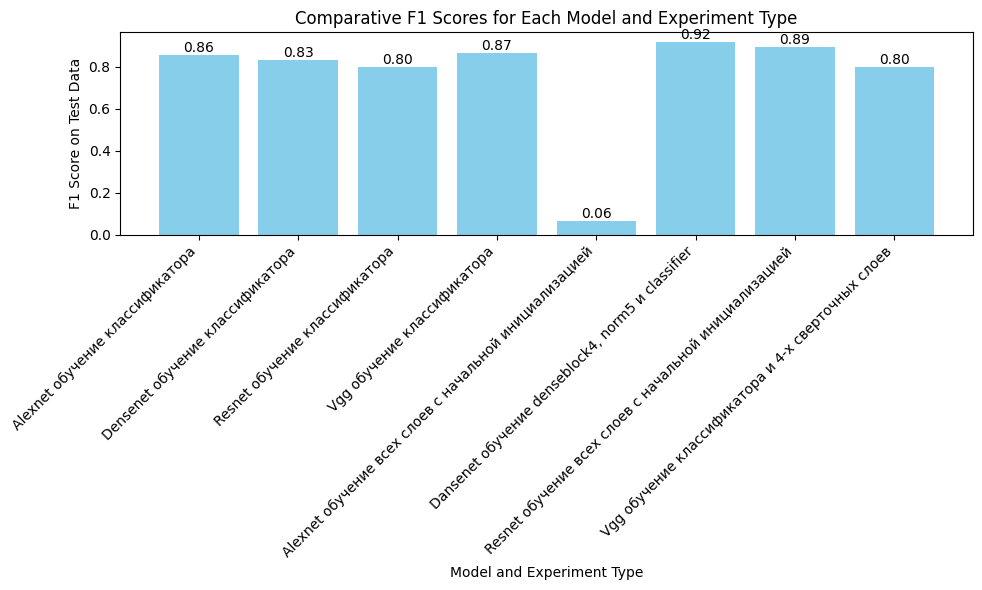

In [87]:
# Создание DataFrame для построения графика
df = pd.DataFrame(results, columns=['Model Experiment', 'F1 Score'])

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model Experiment'], df['F1 Score'], color='skyblue')
plt.xlabel('Model and Experiment Type')
plt.ylabel('F1 Score on Test Data')
plt.title('Comparative F1 Scores for Each Model and Experiment Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения F1-меры на столбики
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()